# MTF de lente ideal: ejemplo en 405 nm

Aquí las funciones ya están implementadas en diffractio
   
   

In [23]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_fields_XZ import Scalar_field_XZ

from diffractio.utils_optics import beam_width_1D, MTF_ideal, MTF_parameters

## Parámetros iniciales

In [26]:
diameter_field = 8*mm
wavelength=.405*um
focal_lens=25*mm

diameter_lens=4*mm
rango_z=10*mm  #zona de observación cuando no voy directo al plano de la retina

num_z=256

x0 = sp.linspace(-diameter_field/2, diameter_field/2, 1024*16)

## Haz generado



In [27]:
f1=Scalar_source_X(x0,wavelength)
f1.plane_wave(A=1,theta=0)

## Lente ideal

distancia focal = 25.00 mm


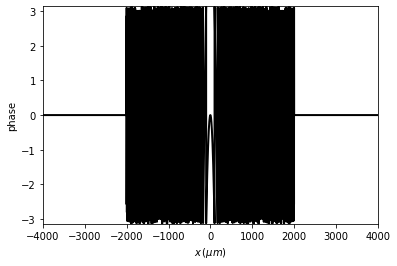

In [28]:
print("distancia focal = {:4.2f} mm".format(focal_lens/1000.))

lens=Scalar_mask_X(x0,wavelength)
lens.lens(focal=focal_lens, radius=diameter_lens/2, x0=0)
lens.draw(kind='phase')

## Propagacíon directa hasta zona focal
Este procedimiento es mucho más rápido, ya que no necesitamos calcular en una zona, sino un único cálculo desde la lente. Tiene el inconveniente que tienes que saber la posición (que calculamos posteriormente

('Good result: factor ', 5.2479763468236005)


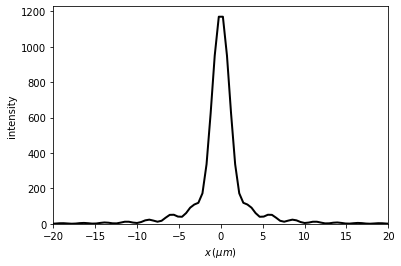

In [29]:
u2=f1*lens

u_foc=u2.RS(n=1, z=focal_lens, new_field=True)
u_foc.draw(kind='intensity')
plt.ylim(bottom=0)
plt.xlim(-20,20);

## MTF

(0, 500)

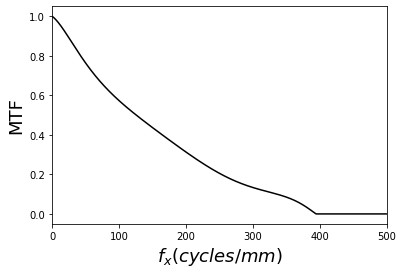

In [30]:
freq_real, mtf_norm = u_foc.MTF(has_draw=True)
plt.xlim(left=0, right=500)

### MTF ideal

frecuencia de corte = 395.06 lineas/mm


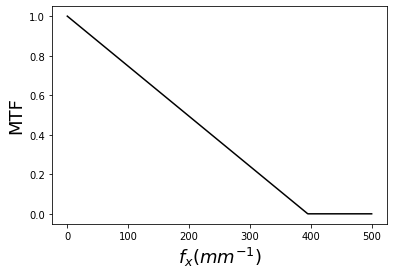

In [31]:
freq_ideal=sp.linspace(0, 500,500) #se supone que son líneas por mm
mtf_ideal, freq_corte=MTF_ideal(freq_ideal, wavelength=wavelength, diameter=diameter_lens,
                        focal=focal_lens, kind='1D', has_draw=True, verbose=True)

### Comparación MTF lente con ideal

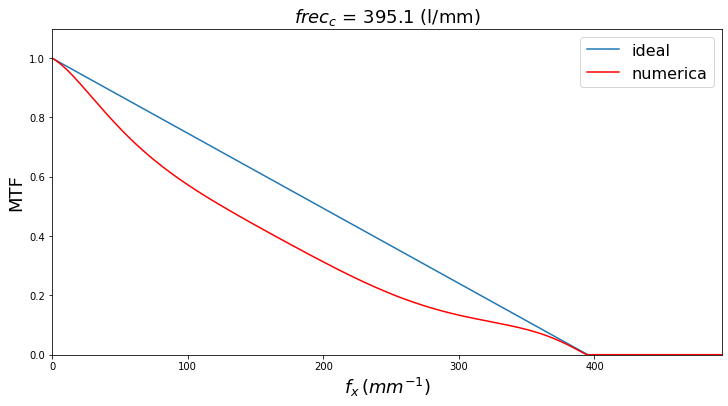

In [32]:
plt.figure(figsize=(12,6))
plt.plot(freq_ideal,mtf_ideal, label='ideal')
plt.xlabel("$f_x\,(mm^{-1})$", fontsize=18)
plt.ylabel("MTF", fontsize=18)
plt.xlim(left=0, right=1.25*freq_corte)
plt.ylim(bottom=0, top=1.1)
plt.title("$frec_c$ = {:2.1f} (l/mm)".format(freq_corte), fontsize=18)

#plt.plot(4*x_mtf_new, mtf_new,'r', label='numerica')
plt.plot(freq_real, mtf_norm,'r', label='numerica')

plt.legend(fontsize=16);

## Parámetros de la MTF

In [33]:
MTF_real=(freq_real, mtf_norm)
MTF_ideal=(freq_ideal, mtf_ideal)
strehl_ratio, mtf_50_ratio, freq_50_real, freq_50_ideal = MTF_parameters(MTF_real, MTF_ideal, verbose=True)

 MTF Parameters:
- Strehl_ratio      = 0.76
- MTF_ratio @ 50.00  = 0.88
- freq @ 50.00  real (lines/mm) = 0.76
- freq @ 50.00  ideal (lines/mm) = 0.87


## Propagación después de la lente un rango z

In [34]:
z0=sp.linspace(focal_lens-rango_z/2, focal_lens+rango_z/2,num_z)
u3 = Scalar_field_XZ(x=x0, z=z0, wavelength=wavelength)
u3.n_background=1
u3.incident_field(u2)
u3.RS(num_processors=16, verbose=True);

Good result: factor 4.23
time in RS= 38.23544383049011. num proc= 16


(-200.0, 200.0)

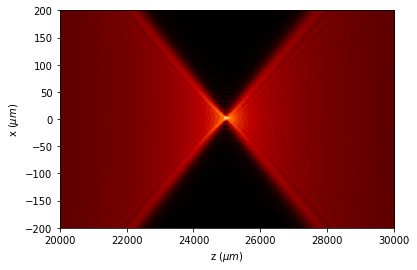

In [35]:
u3.draw(logarithm=True, normalize='intensity', draw_borders=False)
plt.ylim(-200 * um, 200 * um)

### Calculo de posición focal y perfiles longitudinal y transversal

x = 0.244 um, z = 24980.392 um


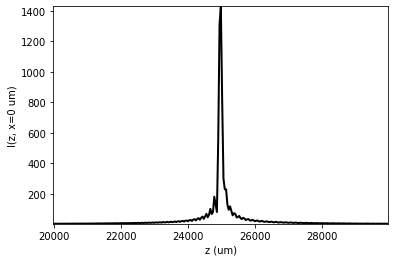

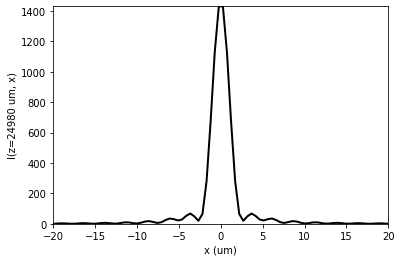

In [36]:
x_f, z_f = u3.search_focus()
u3.profile_longitudinal(x0=x_f, draw=True, filename='')
plt.xlim(z_f-5*mm,z_f+5*mm)

u3.profile_transversal(z0=z_f, draw=True, filename='')
plt.xlim(-20*um, 20*um);

### Función que nos dice donde tenemos energía, para automatizar las figuras

In [37]:
def pos_energia(u3, porcentaje=0.05, verbose=True):

    intensidad=np.abs(u3.u)**2
    perfil_x=intensidad.mean(axis=1)
    perfil_z=intensidad.mean(axis=0)

    corte=porcentaje*perfil_x.max()
    is_high=perfil_x>corte
    
    xmin=np.min(u3.x[is_high])
    xmax=np.max(u3.x[is_high])

    if verbose is True:
        plt.figure()
        plt.plot(u3.x,perfil_x>corte)
        print("  {}, {}". format(xmin,xmax))

        plt.figure()
        plt.plot(u3.x, perfil_x)

        plt.figure()
        plt.plot(u3.z, perfil_z)
       
    return (xmin,xmax)

In [38]:
x_min,x_max=pos_energia(u3, porcentaje=0.01, verbose=False)

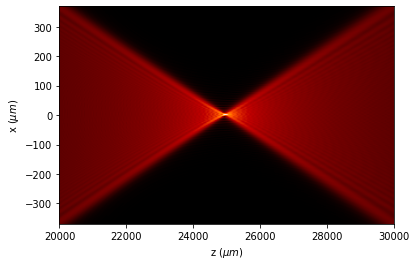

In [39]:
u3.draw(logarithm=True, normalize='intensity', draw_borders=False)
plt.ylim(x_min,x_max);

### Cálculo de la anchura y de la posición del beam

In [40]:
def beam_widths(u3):
    anchuras=np.zeros_like(u3.z)
    posiciones=np.zeros_like(u3.z)

    for i in range(len(u3.z)):
        field=abs(u3.u[:,i])
        anchuras[i], posiciones[i]= beam_width_1D(field, u3.x)
        
    return anchuras, posiciones

Text(0.5, 1.0, 'anchura')

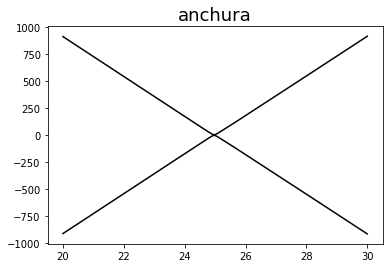

In [41]:
anchuras, posiciones = beam_widths(u3)

plt.figure()
plt.subplot(1,1,1)
plt.plot((u3.z)/1000,  anchuras, 'k')
plt.plot((u3.z)/1000,  -anchuras, 'k')
plt.title('anchura', fontsize=18)

(-80, 80)

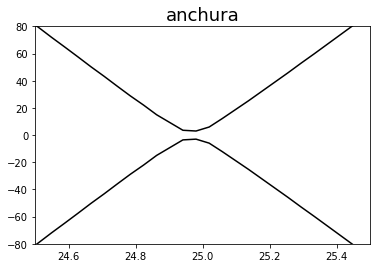

In [42]:
plt.figure()
plt.subplot(1,1,1)
plt.plot((u3.z)/1000,  anchuras, 'k')
plt.plot((u3.z)/1000,  -anchuras, 'k')
plt.title('anchura', fontsize=18)
plt.xlim(focal_lens/mm-0.5,focal_lens/mm+0.5)
plt.ylim(-80,80)

## Conclusiones

1. Parece que la función funciona bien. 

1. He implementado beam_widths() en scalar_fields_XZ a partir de estos resultados



